In [50]:
%load_ext autoreload
%autoreload 2
from ITL_utils import deep_JSD
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import repitl.kernel_utils as ku
from utils import stacked_mnist_multiview_dataset, visualize_dataset, get_truncated_noise
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from models import DeepFourierFeaturesNetwork_FC, DeepFourierFeaturesNetwork_Conv, Discriminator, Generator, weights_init, DeepFourierFeatures_residual, weights_init_DFFN


from torchvision.utils import save_image


from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.optim.lr_scheduler import StepLR
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


torch.Size([500, 3, 64, 64])


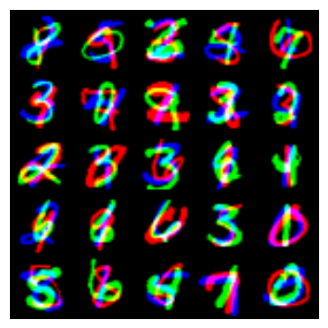

In [51]:
dataset = stacked_mnist_multiview_dataset()
dataloader = DataLoader(dataset=dataset, 
                         batch_size=500, 
                         shuffle=True)

img_size = (3,64,64)
visualize_dataset(dataloader, img_size=img_size, sidesize=5)


In [75]:
params = {
    "discriminator_architecture" : 'convolutional', # residual # 'fully_connected',  'convolutional' or 'DCGAN'
    "bsize" : 64,# Batch size during training.
    'imsize' : 64,# Spatial size of training images. All images will be resized to this size during preprocessing.
    'nc' : 3,# Number of channles in the training images. For coloured images this is 3.
    'nz' : 100,# Size of the Z latent vector (the input to the generator).
    'ngf' : 64,# Size of feature maps in the generator. The depth will be multiples of this.
    'ndf' : 64, # Size of features maps in the discriminator. The depth will be multiples of this.
    'd_out' :256, # size of the output of the discriminator
    'FF' : 4, # Number of Fourier Features
    'nepochs' : 15,# Number of training epochs.
    'truncation': 0.5, # truncation parameter of the gaussian noise
    'd_updates' : 1,# Number of discriminator updates per generator update.
    'lr_d' : 0.00002,# Learning rate for optimizers
    'lr_g' : 0.0001,# Learning rate for optimizers
    'beta1' : 0.5,# Beta1 hyperparam for Adam optimizer
    'weight_decay' : 0.0, # weight decay for the Adam optimizer
    'save_epoch' : 2, # Save step.
    'plot_loss': True,
    'scheduler': False,
    'schedule_interval': 5,
    'gamma': 0.9}



sample_interval = 1 # epochs
schedule_interval = params['schedule_interval']
cuda = True if torch.cuda.is_available() else False
# Use GPU is available else use CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")

lr_d = params['lr_d']
lr_g = params['lr_g']
b1 = params['beta1']
b2 = 0.999
n_epochs = params['nepochs']
latent_dim = params['nz']
d_updates = params['d_updates']
g_updates = 1

dataloader = DataLoader(dataset=dataset, 
                         batch_size=params['bsize'], 
                         shuffle=True)

I observed that using beta1 = 0.9 for the discriminator works better.

In [76]:

# Create the generator.
generator = Generator(params['imsize'], params['nz'], params['ngf'], params['nc']).to(device)
# FourierFeatureNet = DeepFourierFeaturesNetwork(params['imsize'], params['ngf'], params['nc'], 10, params['FF']).to(device)

# Use the corresponding architecture for the discriminator.
if params['discriminator_architecture'] == 'fully_connected':
    FourierFeatureNet = DeepFourierFeaturesNetwork_FC(img_size, params['d_out'], params['FF']).to(device)
elif params['discriminator_architecture'] == 'convolutional':
    FourierFeatureNet = DeepFourierFeaturesNetwork_Conv(params['nc'], params['ndf'], params['FF']).to(device)
    # FourierFeatureNet.apply(weights_init_DFFN)
elif params['discriminator_architecture'] == 'residual':
    FourierFeatureNet = DeepFourierFeatures_residual(params['nc'], params['ndf'], params['FF']).to(device)
    FourierFeatureNet.apply(weights_init_DFFN)

generator.apply(weights_init)

if cuda:
    generator.cuda()
    FourierFeatureNet.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(b1, b2))
# optimizer_G = torch.optim.SGD(generator.parameters(), lr=lr_g,momentum=0.9)
# optimizer_D = torch.optim.SGD(FourierFeatureNet.parameters(), lr=lr_d, momentum=0.9) #0.05
optimizer_D = torch.optim.Adam(FourierFeatureNet.parameters(), lr=lr_d, betas=(b1, b2), weight_decay=params['weight_decay']) #0.05
scheduler = StepLR(optimizer_D, step_size=5, gamma=params['gamma'])
scheduler_g = StepLR(optimizer_G, step_size=5, gamma=params['gamma'])
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor



In [77]:
# fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)
fixed_noise = get_truncated_noise(64, params['nz'], params['truncation']).to(device) # 2 std truncation 
# ----------
#  Training
# ----------
loss_gen = np.zeros((n_epochs +1) * len(dataloader.dataset) // params['bsize'])
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        # Sample noise as generator input
        z = Variable(get_truncated_noise(imgs.shape[0], params['nz'], params['truncation'])).to(device)
        
        # Generate a batch of images
        gen_imgs = generator(z)


        # ---------------------
        #  Train Discriminator
        # ---------------------            

        
        for k in range(d_updates):  

            optimizer_D.zero_grad()
            d_loss = -1*deep_JSD(real_imgs,gen_imgs.detach(),FourierFeatureNet)
            d_loss.backward()
            optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        for k in range(g_updates):
            z = Variable(get_truncated_noise(imgs.shape[0], params['nz'], params['truncation'])).to(device)

            # Generate a batch of images
            gen_imgs = generator(z)
            optimizer_G.zero_grad()
            g_loss = deep_JSD(real_imgs,gen_imgs,FourierFeatureNet)
            g_loss.backward()
            optimizer_G.step()



        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), -1*d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        # Saving loss to plot later
        loss_gen[batches_done] = g_loss.item()
    if params['scheduler']:
        if epoch % schedule_interval == 0:
            print('Initial learning rate: ', optimizer_D.param_groups[0]['lr'])
        # step in the scheduler
            scheduler.step()
            scheduler_g.step()

    if epoch % sample_interval == 0:
        with torch.no_grad():
            fixed_gen_imgs = generator(fixed_noise).detach().cpu()
        save_image(fixed_gen_imgs.data[:64], "images/%d_dJSD.pdf" % epoch, nrow=8, normalize=True)


with torch.no_grad():
    fixed_gen_imgs = generator(fixed_noise).detach().cpu()
save_image(fixed_gen_imgs.data[:64], "images/final_dJSD_convolutional.pdf", nrow=8, normalize=True)

if params['plot_loss']:

    plt.plot(loss_gen[:batches_done])
    plt.xlabel('Step')
    plt.ylabel(r'$D_{JS}$')
    plt.title('Loss generator')
    plt.savefig(os.path.join('images/', 'loss_gen_conv.pdf'),dpi=300, bbox_inches='tight')
    plt.close()
    # scheduler.step()

[Epoch 0/15] [Batch 0/938] [D loss: 0.003903] [G loss: 0.062684]
[Epoch 0/15] [Batch 1/938] [D loss: 0.037943] [G loss: 0.130672]
[Epoch 0/15] [Batch 2/938] [D loss: 0.100720] [G loss: 0.232940]
[Epoch 0/15] [Batch 3/938] [D loss: 0.191227] [G loss: 0.361821]
[Epoch 0/15] [Batch 4/938] [D loss: 0.311560] [G loss: 0.515132]
[Epoch 0/15] [Batch 5/938] [D loss: 0.462060] [G loss: 0.679612]
[Epoch 0/15] [Batch 6/938] [D loss: 0.640695] [G loss: 0.841138]
[Epoch 0/15] [Batch 7/938] [D loss: 0.803358] [G loss: 0.944839]
[Epoch 0/15] [Batch 8/938] [D loss: 0.923286] [G loss: 0.978313]
[Epoch 0/15] [Batch 9/938] [D loss: 0.982646] [G loss: 0.975366]
[Epoch 0/15] [Batch 10/938] [D loss: 0.971978] [G loss: 0.988446]
[Epoch 0/15] [Batch 11/938] [D loss: 0.986718] [G loss: 0.994300]
[Epoch 0/15] [Batch 12/938] [D loss: 0.994879] [G loss: 0.993676]
[Epoch 0/15] [Batch 13/938] [D loss: 0.991360] [G loss: 0.994645]
[Epoch 0/15] [Batch 14/938] [D loss: 0.994337] [G loss: 0.996417]
[Epoch 0/15] [Batch 

In [90]:
from evals import ModeCollapseEval
mc_eval = ModeCollapseEval(n_stack = 3, z_dim = params['nz'])
generator.eval()
print("-" * 100)
n_modes = np.zeros(5)
kld = np.zeros(5)
for i in range(5):
    print("Iteration: ", i)
    n_modes[i], kld[i] = mc_eval.count_modes(generator)

print("Number of modes captured: ", np.mean(n_modes), "+-", np.std(n_modes))
print("Reverse KL: ", np.mean(kld), "+-", np.std(kld) )
print("-" * 100)

----------------------------------------------------------------------------------------------------
Iteration:  0


100%|██████████| 26/26 [00:02<00:00, 12.33it/s]


No. of modes captured:  1000
Reverse KL:  0.04901967275632601
Iteration:  1


100%|██████████| 26/26 [00:02<00:00, 12.81it/s]


No. of modes captured:  1000
Reverse KL:  0.0499525517578622
Iteration:  2


100%|██████████| 26/26 [00:02<00:00, 12.70it/s]


No. of modes captured:  1000
Reverse KL:  0.04909879766180614
Iteration:  3


100%|██████████| 26/26 [00:02<00:00, 12.81it/s]


No. of modes captured:  1000
Reverse KL:  0.046635630194771995
Iteration:  4


100%|██████████| 26/26 [00:02<00:00, 12.63it/s]

No. of modes captured:  1000
Reverse KL:  0.047440159719606974
Number of modes captured:  1000.0 +- 0.0
Reverse KL:  0.04842936241807466 +- 0.00120935626458118
----------------------------------------------------------------------------------------------------


In [78]:
PATH_g = 'saved_models/generator_dJSD_conv.pth'
PATH_d = 'saved_models/discriminator_dJSD_conv.pth'
torch.save(generator.state_dict(), PATH_g)
torch.save(FourierFeatureNet.state_dict(), PATH_d)